In [1]:
#Read in standard packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd

In [2]:
#read in ML packages/modules
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from model_prep import get_feature_name, model_transformer_train

In [3]:
#Read in dask package and set up to allow for faster compute times. Distributes computing among all availabel preocessors
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

(<Scheduler: "tcp://127.0.0.1:63779" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:63796, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:63802, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:63799, threads: 2>})

# Model Accuracy Over Time

This model can be used over time to predict which wellpoints require more maintenance and more generaly which types of wellpoints require more maintenance. As more inspections are completed the model will train on more data and this will improve the overall accuracy as time goes on. To prove this we will take a look at how the model had improved over time already. 

In [4]:
#read in data
model_data = pd.read_pickle('Data/model_data.pkl')

In [5]:
#Create column lists to use as inputs for the StandardScaler and OneHotEncoder Pipeline
num_cols = ['gps_height', 'population', 'amount_tsh', 'years_old']
cat_cols = ['basin', 'region_code', 'district_code', 'extraction_type', 'payment_type', 'water_quality', 'quantity', 
            'source', 'management', 'management_group', 'waterpoint_type',  'funder', 'installer', 'subvillage', 
            'ward', 'scheme_management', 'scheme_name', 'popbins', 'lga', 'urban_rural', 'tsh_rank', 'month']

In [6]:
#Set up instances of StanardSCaler, OneHotEncoder and ColumnTransformer to process model_data
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore')
CT = ColumnTransformer(remainder='passthrough', transformers=[('scaler', scaler, num_cols),
                                              ('ohe', ohe, cat_cols)], verbose=True, sparse_threshold=0)

In [7]:
def prep_train_year(unprepped_values, class_col, year):
    #transforms clean data from EDA notebook into model ready train and test data
    data = unprepped_values.copy()
    train_X = data.loc[data['year']<year].drop(columns=[class_col])
    train_y = data.loc[data['year']<year, class_col]
    test_X = data.loc[data['year']==year].drop(columns=[class_col])
    test_y = data.loc[data['year']==year, class_col]
    
    #run ColumnTransformer fit on training data only
    train_Xct = CT.fit_transform(train_X)
    
    #transform test data based on training fit
    test_Xct = CT.transform(test_X)

    #get columns names from ColumnTransformer
    cols = get_feature_name(CT)
    train_Xf = pd.DataFrame(train_Xct, columns=cols)
    cols = get_feature_name(CT)
    test_Xf = pd.DataFrame(test_Xct, columns=cols)
    
    #Output training and testing dependent and independent variables
    return train_Xf, train_y, test_Xf, test_y   

We will start by taking a look at year over year changes to model accuracy. We will only include 2011, 2012 and 2013 as there are relatively few inspections recorded before these years. Each year will be predicted based only on the inspections that came before it. This is would be similar to a look ahead done during budgeting time to get a baseline for how often wellpoints would be down and in what areas, allowing more targeted planning.

In [8]:
#We wil use the RandomForest Classifier that we found to perform well for both performance and computation time
rf = RandomForestClassifier(n_estimators=250, criterion='gini', class_weight='balanced_subsample', verbose=True)        
years = [2011, 2012, 2013]
year_score = {'year_predicted':[], 'accuracy':[], 'train_data':[], 'test_data':[]}
for year in years:
        X, y, tX, ty = prep_train_year(model_data, 'class', year)
        with joblib.parallel_backend('dask'):
            rf.fit(X, np.ravel(y))
        year_score['year_predicted'].append(year)
        year_score['accuracy'].append(rf.score(tX, ty))
        year_score['train_data'].append(len(y))
        year_score['test_data'].append(len(ty))
year_score

[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.1s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.2s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   14.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.7s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.3s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   20.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    2.9s finished


{'year_predicted': [2011, 2012, 2013],
 'accuracy': [0.5547883099672177, 0.6983188044831881, 0.7139384450578881],
 'train_data': [31, 28705, 35129],
 'test_data': [28674, 6424, 24271]}

In [9]:
year_score_df = pd.DataFrame(year_score)
year_score_df

,year_predicted,accuracy,train_data,test_data
0,2011,0.554788,31,28674
1,2012,0.698319,28705,6424
2,2013,0.713938,35129,24271


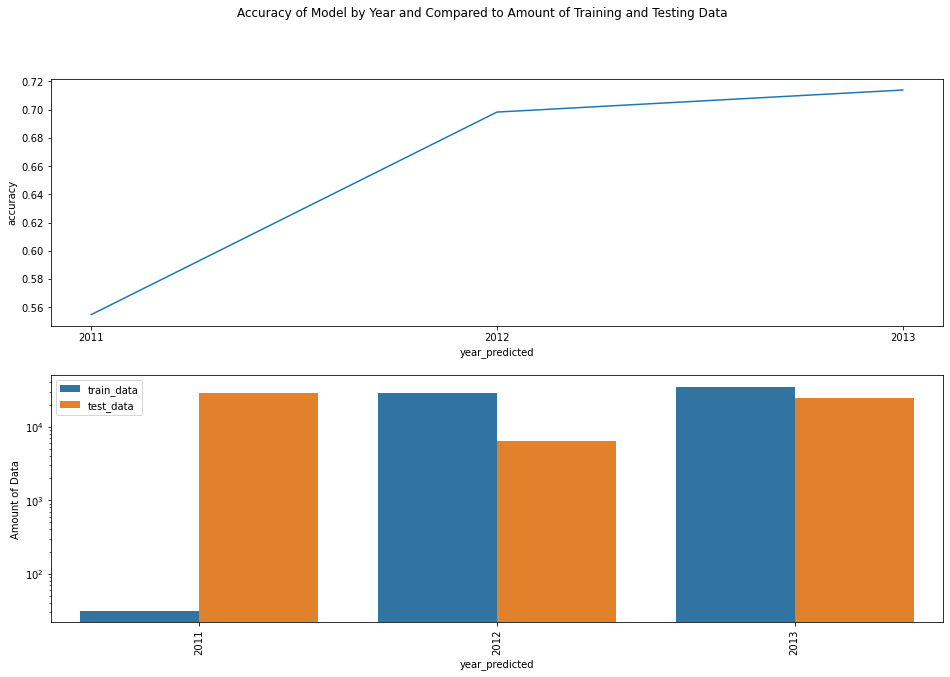

In [10]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 10))
fig.suptitle('Accuracy of Model by Year and Compared to Amount of Training and Testing Data')
sns.lineplot(data=year_score_df, x='year_predicted', y='accuracy', ax=ax1)
ax1.set_xticks([2011, 2012, 2013])
sns.barplot(data=pd.melt(year_score_df.drop(columns='accuracy'), id_vars='year_predicted'), x='year_predicted', 
            y='value', ax=ax2, hue='variable')
ax2.set_ylabel('Amount of Data')
ax2.set_yscale('log')
plt.xticks(rotation=90)
ax2.legend()
plt.show()

The graph above clearly shows an increase as more data is used for train which happens as time goes by. It is likely the incremental changes will be smaller as the accuracy increases and closes in on the max accuracy. Investigations into subsets of the data that are harder to predict could additional help the model's accuracy to improve.

We can also take a look at the model on a month to month basis to see how much improvement we see as each month goes by.

In [11]:
def prep_train_month(unprepped_values, class_col, year, month):
    #transforms clean data from EDA notebook into model ready train and test data
    data = unprepped_values.copy()
    
    not_in_train = data.loc[(data['year']>=year) & (data['month']>=month)]
    test_in = data.loc[(data['year']==year) & (data['month']==month)]
    train_X = data.loc[~data.index.isin(not_in_train.index)].drop(columns=[class_col])
    train_y = data.loc[~data.index.isin(not_in_train.index), class_col]
    test_X = data.loc[data.index.isin(test_in.index)].drop(columns=[class_col])
    test_y = data.loc[data.index.isin(test_in.index), class_col]
        
    #run ColumnTransformer fit on training data only
    train_Xct = CT.fit_transform(train_X)
    
    #transform test data based on training fit
    test_Xct = CT.transform(test_X)

    #get columns names from ColumnTransformer
    cols = get_feature_name(CT)
    train_Xf = pd.DataFrame(train_Xct, columns=cols)
    cols = get_feature_name(CT)
    test_Xf = pd.DataFrame(test_Xct, columns=cols)
    
    #Output training and testing dependent and independent variables
    return train_Xf, train_y, test_Xf, test_y   

In [12]:
rf = RandomForestClassifier(n_estimators=250, criterion='gini', class_weight='balanced_subsample', verbose=True)        
years = [2011]#, 2012, 2013]
months = range(1,13)
month_score = {'month_predicted':[], 'accuracy':[], 'train_data':[], 'test_data':[]}
for year in years:
    for month in months:
        if month in model_data.loc[model_data['year']==year, 'month'].unique():
            X, y, tX, ty = prep_train_month(model_data, 'class', 2011, month)
            with joblib.parallel_backend('dask'):
                rf.fit(X, np.ravel(y))
            month_score['month_predicted'].append('{year}-{month}'.format(year=year, month=month))
            month_score['accuracy'].append(rf.score(tX, ty))
            month_score['train_data'].append(len(y))
            month_score['test_data'].append(len(ty))
month_score

[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.0s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 239 out of 250 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.2s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.2s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    9.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.5s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.4s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   23.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.5s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.4s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   24.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.4s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   23.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.3s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   24.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.9s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.4s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   32.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.4s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.4s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   33.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.5s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   32.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.5s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   35.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.5s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   42.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


{'month_predicted': ['2011-1',
  '2011-2',
  '2011-3',
  '2011-4',
  '2011-5',
  '2011-6',
  '2011-7',
  '2011-8',
  '2011-9',
  '2011-10',
  '2011-11',
  '2011-12'],
 'accuracy': [0.9292929292929293,
  0.7635256180580438,
  0.7365208545269583,
  0.6433489396860369,
  1.0,
  0.9587628865979382,
  0.7072105976215566,
  0.7145545796737767,
  0.7176470588235294,
  0.8172043010752689,
  0.9469026548672567,
  0.9537037037037037],
 'train_data': [31,
  6384,
  18786,
  36717,
  40685,
  41019,
  41364,
  48291,
  51653,
  51979,
  57444,
  58793],
 'test_data': [99, 2791, 11796, 3631, 30, 97, 6643, 3188, 85, 93, 113, 108]}

In [13]:
month_score_df = pd.DataFrame(month_score)
month_score_df

,month_predicted,accuracy,train_data,test_data
0,2011-1,0.929293,31,99
1,2011-2,0.763526,6384,2791
2,2011-3,0.736521,18786,11796
3,2011-4,0.643349,36717,3631
4,2011-5,1.000000,40685,30
5,2011-6,0.958763,41019,97
6,2011-7,0.707211,41364,6643
7,2011-8,0.714555,48291,3188
8,2011-9,0.717647,51653,85
9,2011-10,0.817204,51979,93


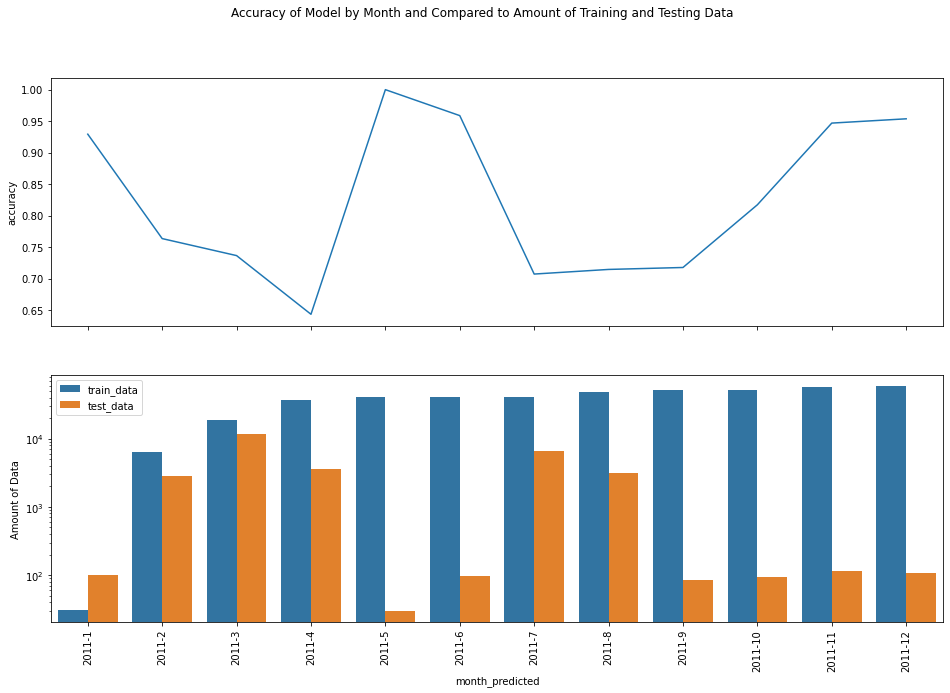

In [14]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16, 10))
fig.suptitle('Accuracy of Model by Month and Compared to Amount of Training and Testing Data')
sns.lineplot(data=month_score_df, x='month_predicted', y='accuracy', ax=ax1)
sns.barplot(data=pd.melt(month_score_df.drop(columns='accuracy'), id_vars='month_predicted'), x='month_predicted', 
            y='value', ax=ax2, hue='variable')
ax2.set_ylabel('Amount of Data')
ax2.set_yscale('log')
plt.xticks(rotation=90)
ax2.legend()
plt.show()

There appears to be some noise when zooming into each month. This is likely a combination of seasonal patterns on function of wellpoints, amount of inspections, ease of maintenance and available remaining budget. Let's zoom a little farther out to every 3 months and see if a pattern is more discernable. 

In [15]:
rf = RandomForestClassifier(n_estimators=250, criterion='gini', class_weight='balanced_subsample', verbose=True)        
years = [2011, 2012, 2013]
months = range(0,13, 3)
month3_score = {'month_predicted':[], 'accuracy':[], 'train_data':[], 'test_data':[]}
for year in years:
    for month in months:
        if month in model_data.loc[model_data['year']==year, 'month'].unique():
            X, y, tX, ty = prep_train_month(model_data, 'class', year, month)
            with joblib.parallel_backend('dask'):
                rf.fit(X, np.ravel(y))
            month3_score['month_predicted'].append('{year}-{month}'.format(year=year, month=month))
            month3_score['accuracy'].append(rf.score(tX, ty))
            month3_score['train_data'].append(len(y))
            month3_score['test_data'].append(len(ty))
month3_score

[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.2s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   10.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.4s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.3s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   24.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.5s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   32.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.5s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   36.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.5s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   38.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.6s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   28.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.8s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.5s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   32.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.4s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   33.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


[ColumnTransformer] ........ (1 of 3) Processing scaler, total=   0.0s
[ColumnTransformer] ........... (2 of 3) Processing ohe, total=   0.4s
[ColumnTransformer] ..... (3 of 3) Processing remainder, total=   0.0s


C:\Users\bwils\OneDrive\Documents\GitHub\Pump-it-up\model_prep\gfn.py:36: UserWarning: Transformer scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   34.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished


{'month_predicted': ['2011-3',
  '2011-6',
  '2011-9',
  '2011-12',
  '2012-12',
  '2013-3',
  '2013-6',
  '2013-9',
  '2013-12'],
 'accuracy': [0.7390640895218719,
  0.9587628865979382,
  0.6588235294117647,
  0.9444444444444444,
  0.7733333333333333,
  0.7553382233088834,
  0.7620967741935484,
  0.9336099585062241,
  0.8576642335766423],
 'train_data': [18786, 41019, 51653, 58793, 58901, 50992, 57768, 58474, 59126],
 'test_data': [11796, 97, 85, 108, 225, 6135, 248, 241, 274]}

In [16]:
month3_score_df = pd.DataFrame(month3_score)
month3_score_df

,month_predicted,accuracy,train_data,test_data
0,2011-3,0.739064,18786,11796
1,2011-6,0.958763,41019,97
2,2011-9,0.658824,51653,85
3,2011-12,0.944444,58793,108
4,2012-12,0.773333,58901,225
5,2013-3,0.755338,50992,6135
6,2013-6,0.762097,57768,248
7,2013-9,0.933610,58474,241
8,2013-12,0.857664,59126,274


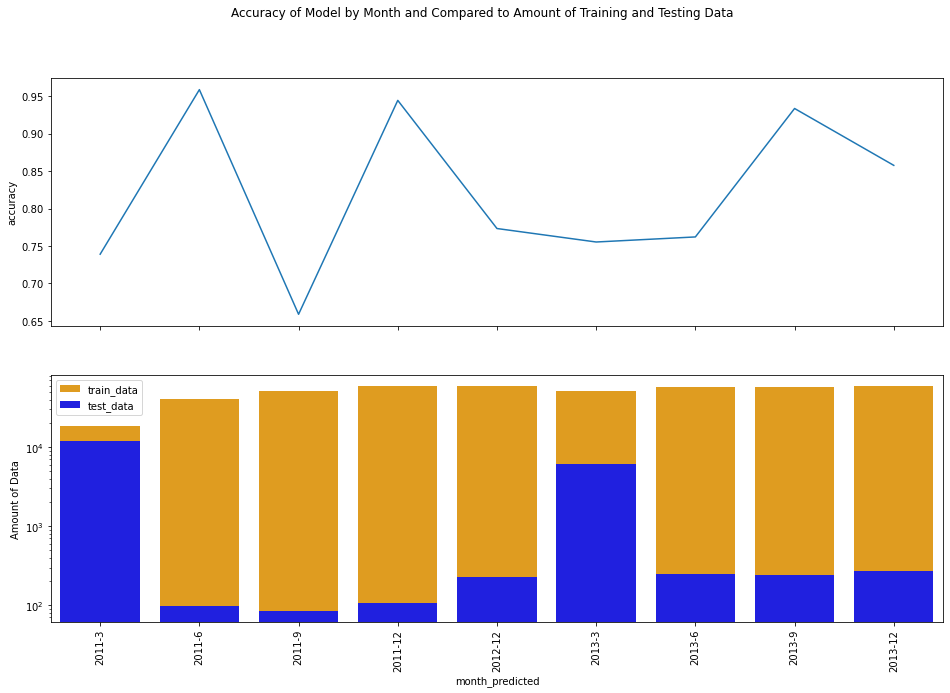

In [17]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(16, 10))
fig.suptitle('Accuracy of Model by Month and Compared to Amount of Training and Testing Data')
sns.lineplot(data=month3_score_df, x='month_predicted', y='accuracy', ax=ax1)
sns.barplot(data=month3_score_df, x='month_predicted', y='train_data', ax=ax2, color='orange', label='train_data')
sns.barplot(data=month3_score_df, x='month_predicted', y='test_data', ax=ax2, color='blue', label='test_data')
ax2.set_ylabel('Amount of Data')
ax2.set_yscale('log')
plt.xticks(rotation=90)
ax2.legend()
plt.show()

The visual above shows a good representation of the increase in the model accuracy over time. Though large dumps of inspections can cause problems for the model as the historical training data constinues to increase the difference between the train set and the testing set will be more consistently large. We can see that when we have a large difference between these two values we have a progression upwards for the accuracy of the model.